# Importando as imagems padrão

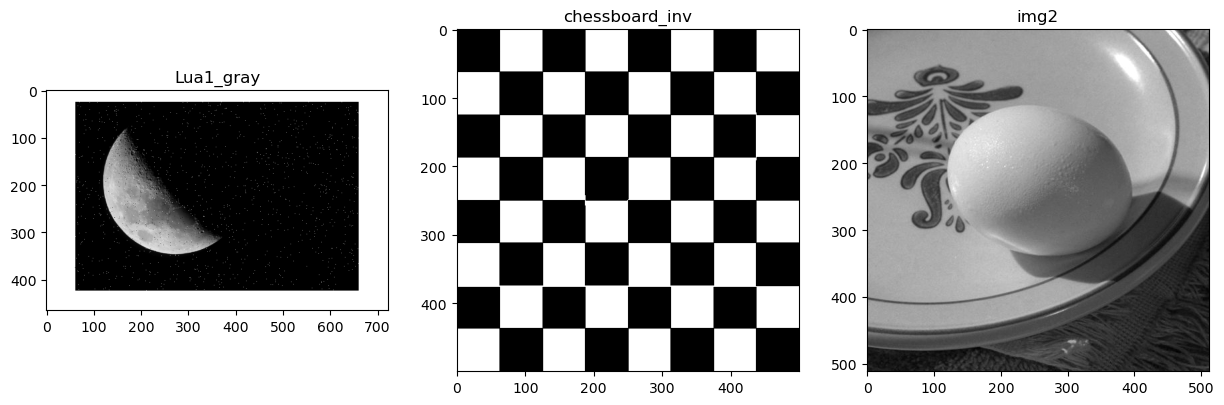

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Carregando as imagens
lua1_gray = cv2.imread('Lua1_gray.jpg', cv2.IMREAD_GRAYSCALE)
chessboard_inv = cv2.imread('chessboard_inv.png', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('img02.jpg', cv2.IMREAD_GRAYSCALE)

# Exibindo as imagens carregadas
plt.figure(figsize=(15,5))
plt.subplot(1,3,1), plt.imshow(lua1_gray, cmap='gray'), plt.title('Lua1_gray')
plt.subplot(1,3,2), plt.imshow(chessboard_inv, cmap='gray'), plt.title('chessboard_inv')
plt.subplot(1,3,3), plt.imshow(img2, cmap='gray'), plt.title('img2')
plt.show()

# Funções Utilitárias

## Vamos aplicar o seguinte pipeline
![img](/home/hnz/PIM/T2/pipeline.png)

## A função custom filter 2D aplica um operador em um imagem utilizando a janela deslizante

In [2]:
def custom_filter2D(image, operator):
    img_height, img_width = image.shape
    op_height, op_width = operator.shape
    # Calcular o padding
    pad_height = op_height // 2
    pad_width = op_width // 2
    
    output = np.zeros_like(image, dtype=np.float64)
    for i in range(pad_height, img_height - pad_height):
        for j in range(pad_width, img_width - pad_width):
            # Aplicar a convolução
            region = image[i - pad_height:i + pad_height + 1, j - pad_width:j + pad_width + 1]
            output[i, j] = np.sum(region * operator)
    
    return output

## a Função gaussian filter cria e aplica um filtro gaussiano usando a função anterior

In [3]:
def gaussian_filter(image, kernel_size=5, sigma=1.0):
    """Aplica um filtro Gaussiano na imagem."""
    # Cria um kernel Gaussiano
    ax = np.linspace(-(kernel_size - 1) / 2., (kernel_size - 1) / 2., kernel_size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    kernel = kernel / np.sum(kernel)
    
    # Aplica o kernel na imagem
    return custom_filter2D(image, kernel)


## A função apply gradient operator aplica o filtro gaussiano (1), a função da janela deslizante para os filtros horizontais e verticais(2.1 e 2.2) e usa as fórmulas descritas no enunciado para obter a magnitide(3) e direção do gradiente(4)

In [4]:

def apply_gradient_operator(image, operator_x, operator_y):
    # (1) Filtragem para atenuar ruído
    smoothed_image = gaussian_filter(image)
    
    grad_x = custom_filter2D(smoothed_image, operator_x)  # (2.2) Gx
    grad_y = custom_filter2D(smoothed_image, operator_y)  # (2.1) Gy
    
    # (3) M: Magnitude do gradiente
    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    magnitude = np.uint8(magnitude)
    
    # (4) D: Direção do gradiente
    direction = np.arctan2(grad_y, grad_x)
    
    return magnitude, direction


## Utiliza os métodos descritos nas imagens do enunciado para fazer a seleção dos gradientes(5)
![img](/home/hnz/PIM/T2/angulos.png)

In [5]:

#(5)
def non_max_suppression(magnitude, direction):
    """Realiza a supressão dos não máximos."""
    M, N = magnitude.shape
    output = np.zeros((M, N), dtype=np.int32)
    angle = direction * 180. / np.pi
    angle[angle < 0] += 180  # Transformando ângulos negativos para positivos

    for i in range(1, M-1):
        for j in range(1, N-1):
            try:
                # Horizontal 0°
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = magnitude[i, j+1]
                    r = magnitude[i, j-1]
                # Diagonal 45°
                elif 22.5 <= angle[i,j] < 67.5:
                    q = magnitude[i+1, j-1]
                    r = magnitude[i-1, j+1]
                # Vertical 90°
                elif 67.5 <= angle[i,j] < 112.5:
                    q = magnitude[i+1, j]
                    r = magnitude[i-1, j]
                # Diagonal 135°
                elif 112.5 <= angle[i,j] < 157.5:
                    q = magnitude[i-1, j-1]
                    r = magnitude[i+1, j+1]

                if magnitude[i,j] >= q and magnitude[i,j] >= r:
                    output[i,j] = magnitude[i,j]
                else:
                    output[i,j] = 0

            except IndexError as e:
                pass

    return output


## Histograma dos gradientes seguindo a descrição da Parte 2 da tarefa

![img](/home/hnz/PIM/T2/hog.png)

In [6]:

def histogram_of_gradients(magnitudes, directions, num_buckets=10):
    # Inicializar o histograma com zeros
    histogram = np.zeros(num_buckets)

    # O intervalo de cada bucket
    bucket_range = 180 / num_buckets

    for i in range(directions.shape[0]):
        for j in range(directions.shape[1]):
            # Determinar o índice do bucket para a direção do gradiente atual
            bucket_idx = int(directions[i, j] // bucket_range)
            next_bucket_idx = (bucket_idx + 1) % num_buckets
            
            # Calcula a contribuição para cada bucket com base na proximidade
            remainder = (directions[i, j] % bucket_range) / bucket_range
            histogram[bucket_idx] += magnitudes[i, j] * (1 - remainder)
            histogram[next_bucket_idx] += magnitudes[i, j] * remainder

    return histogram


# Processamento e exibição de Resultados

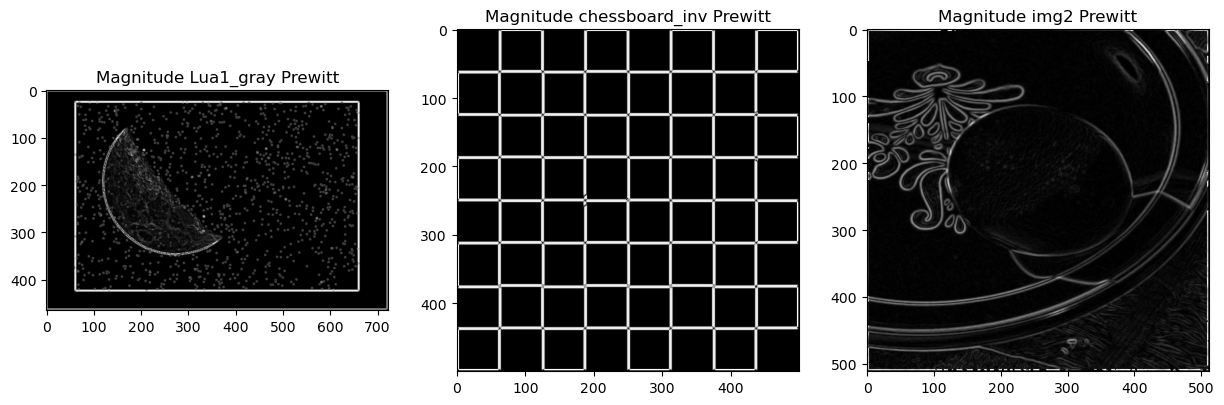

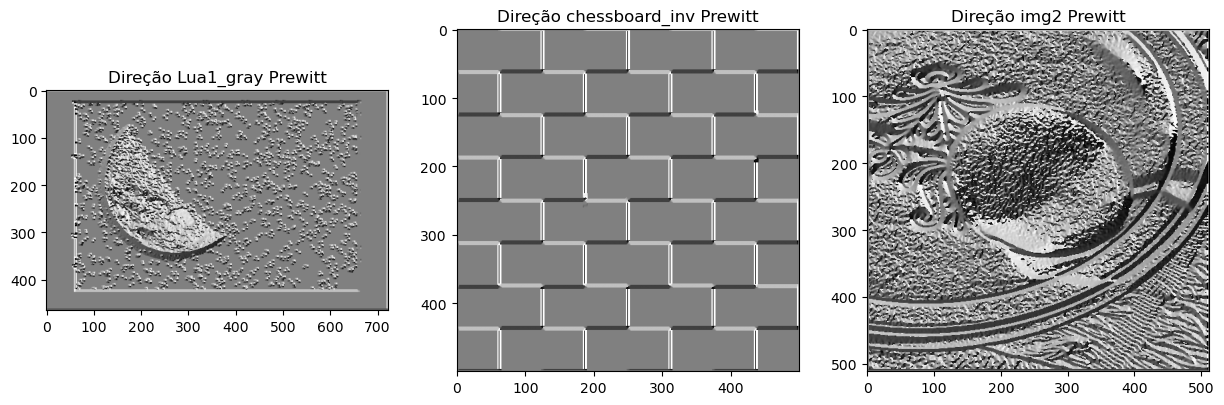

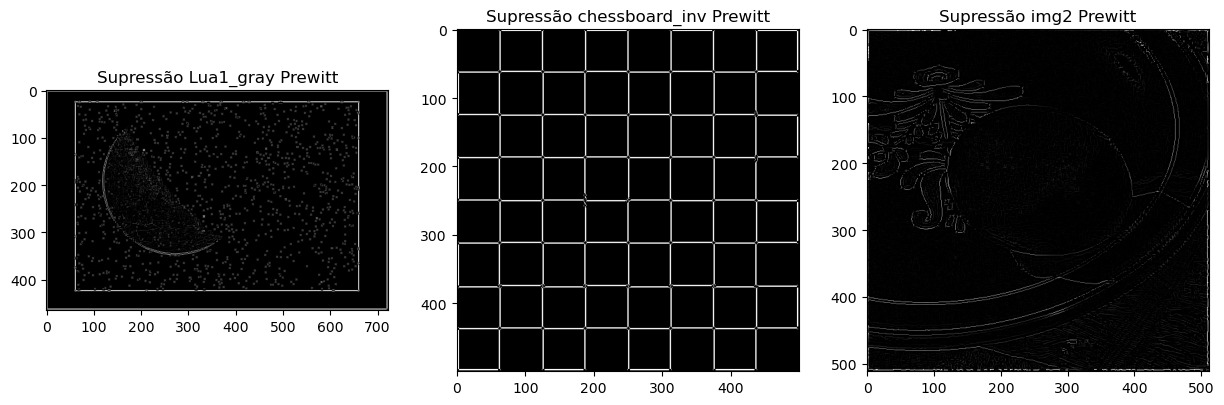

Histograma de gradientes Prewitt para a imagem lua1_gray: 
[5213797.54893628  306913.07811282       0.               0.
       0.               0.               0.               0.
       0.          199757.37295011]

Histograma de gradientes Prewitt para a imagem chessboard_inv: 
[6532333.31293585  395022.29889957       0.               0.
       0.               0.               0.               0.
       0.          229566.38816233]

Histograma de gradientes Prewitt para a imagem img2: 
[4047958.02607631  182604.07048936       0.               0.
       0.               0.               0.               0.
       0.          218978.90343441]



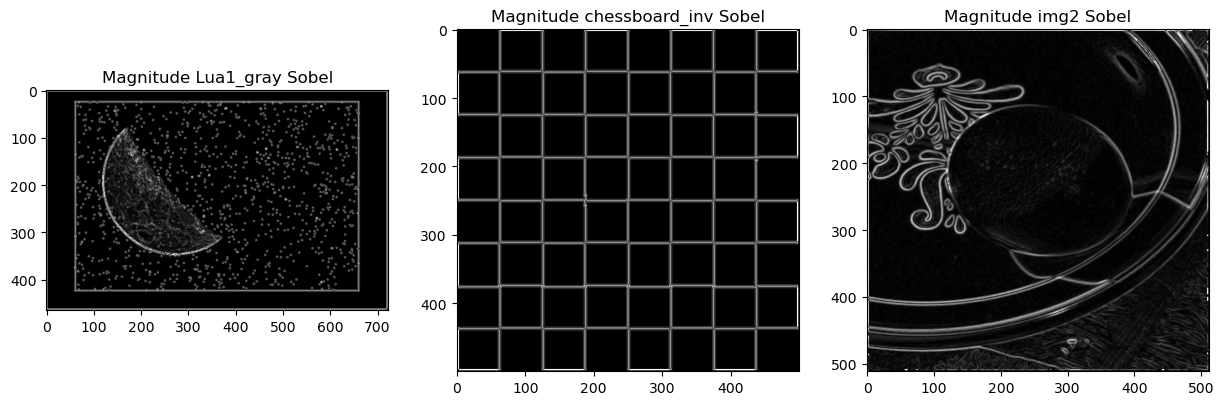

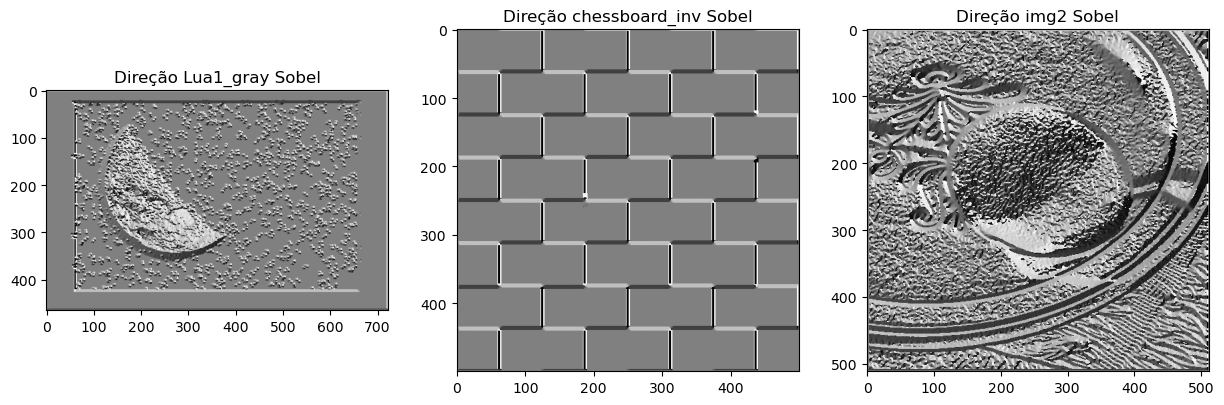

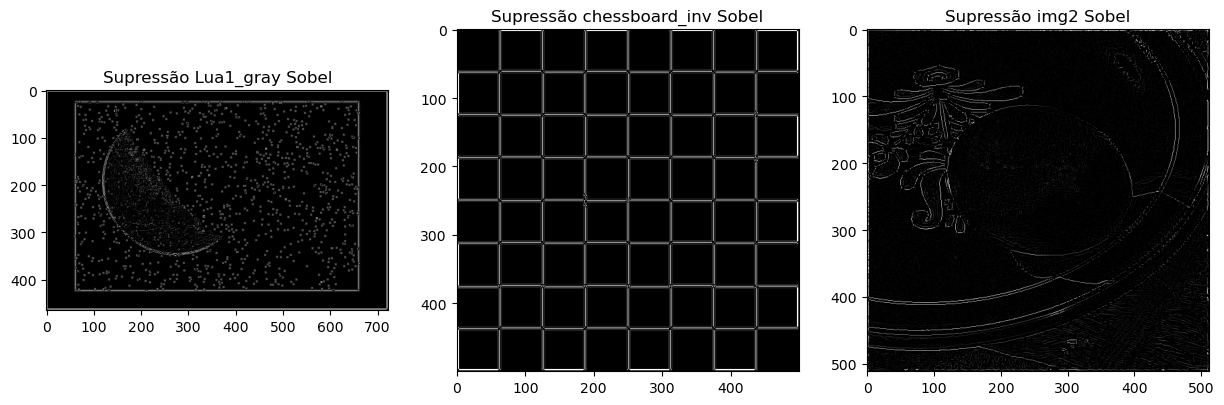

Histograma de gradientes Sobel para a imagem lua1_gray: 
[5087032.00583201  292708.13708002       0.               0.
       0.               0.               0.               0.
       0.          205831.85708733]

Histograma de gradientes Sobel para a imagem chessboard_inv: 
[3491229.12000505  152185.45176834       0.               0.
       0.               0.               0.               0.
       0.          181676.42822636]

Histograma de gradientes Sobel para a imagem img2: 
[5367786.47799424  243400.92038045       0.               0.
       0.               0.               0.               0.
       0.          274616.60162543]



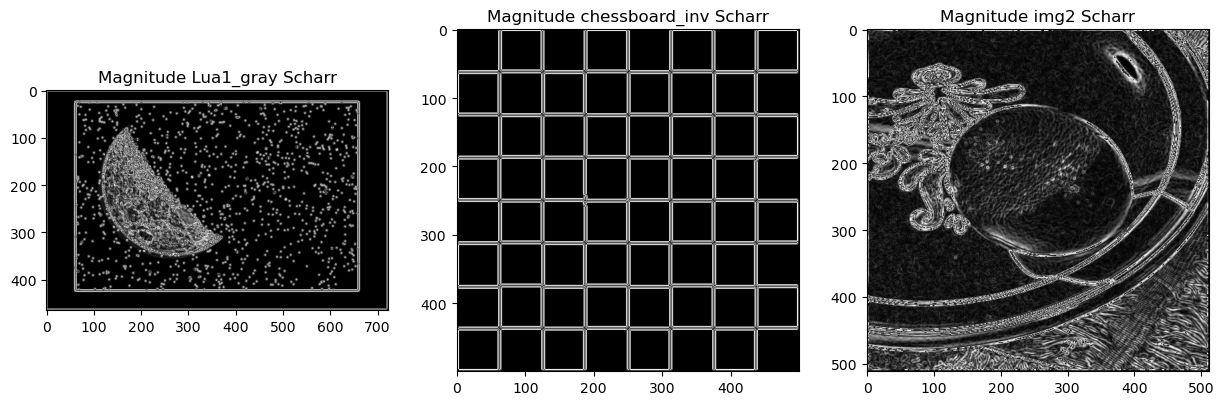

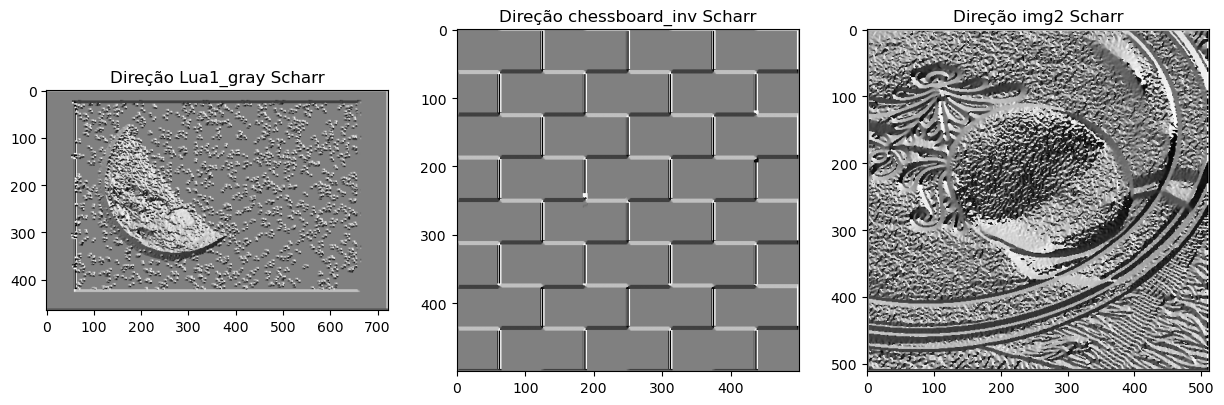

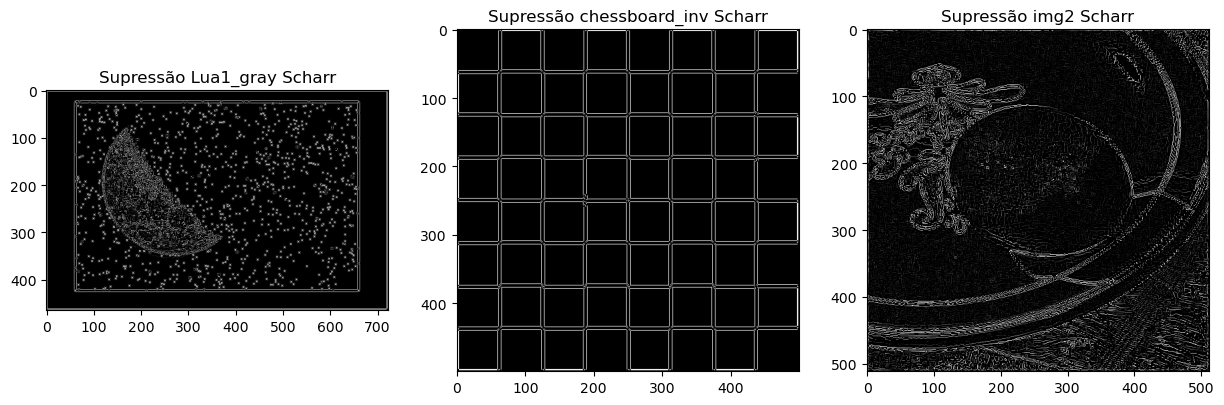

Histograma de gradientes Scharr para a imagem lua1_gray: 
[9060975.74276376  549835.73630908       0.               0.
       0.               0.               0.               0.
       0.          372482.52092763]

Histograma de gradientes Scharr para a imagem chessboard_inv: 
[6296782.23801268  341806.61428403       0.               0.
       0.               0.               0.               0.
       0.          260328.14770282]

Histograma de gradientes Scharr para a imagem img2: 
[13206331.27574473   603046.10296076        0.                0.
        0.                0.                0.                0.
        0.           692492.6212944 ]



In [9]:

def process_and_display(X,Y,nome):
    lua1_gray_mag, lua1_gray_dir = apply_gradient_operator(lua1_gray, X, Y)
    chessboard_inv_mag, chessboard_inv_dir = apply_gradient_operator(chessboard_inv, X, Y)
    img2_mag, img2_dir = apply_gradient_operator(img2, X, Y)

    lua1_gray_supressed = non_max_suppression(lua1_gray_mag, lua1_gray_dir)
    chessboard_inv_supressed = non_max_suppression(chessboard_inv_mag,chessboard_inv_dir)
    img2_supressed = non_max_suppression(img2_mag,img2_dir)

    # Exibindo os resultados
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1), plt.imshow(lua1_gray_mag, cmap='gray'), plt.title(f'Magnitude Lua1_gray {nome}')
    plt.subplot(1,3,2), plt.imshow(chessboard_inv_mag, cmap='gray'), plt.title(f'Magnitude chessboard_inv {nome}')
    plt.subplot(1,3,3), plt.imshow(img2_mag, cmap='gray'), plt.title(f'Magnitude img2 {nome}')
    plt.show()

    # Exibindo os resultados
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1), plt.imshow(lua1_gray_dir, cmap='gray'), plt.title(f'Direção Lua1_gray {nome}')
    plt.subplot(1,3,2), plt.imshow(chessboard_inv_dir, cmap='gray'), plt.title(f'Direção chessboard_inv {nome}')
    plt.subplot(1,3,3), plt.imshow(img2_dir, cmap='gray'), plt.title(f'Direção img2 {nome}')
    plt.show()

    # Exibindo os resultados
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1), plt.imshow(lua1_gray_supressed, cmap='gray'), plt.title(f'Supressão Lua1_gray {nome}')
    plt.subplot(1,3,2), plt.imshow(chessboard_inv_supressed, cmap='gray'), plt.title(f'Supressão chessboard_inv {nome}')
    plt.subplot(1,3,3), plt.imshow(img2_supressed, cmap='gray'), plt.title(f'Supressão img2 {nome}')
    plt.show()

    lua1_gray_hist = histogram_of_gradients(lua1_gray_mag, lua1_gray_dir)
    chessboard_inv_hist = histogram_of_gradients(chessboard_inv_mag, chessboard_inv_dir)
    img2_hist = histogram_of_gradients(img2_mag, img2_dir)
    print(f"Histograma de gradientes {nome} para a imagem lua1_gray: \n{lua1_gray_hist}\n")
    print(f"Histograma de gradientes {nome} para a imagem chessboard_inv: \n{chessboard_inv_hist}\n")
    print(f"Histograma de gradientes {nome} para a imagem img2: \n{img2_hist}\n")

# Operadores de Prewitt
Pwx = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
Pwy = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])

process_and_display(Pwx, Pwy, "Prewitt")

# Operadores de Sobel
Sbx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
Sby = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

process_and_display(Sbx,Sby,"Sobel")

# Operadores de Scharr
Scx = np.array([[-3, 0, 3], [-10, 0, 10], [-3, 0, 3]])
Scy = np.array([[-3, -10, -3], [0, 0, 0], [3, 10, 3]])

process_and_display(Scx,Scy,"Scharr")